# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project, your task is to identify major customer segments on a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## <b> Data Description </b>

### <b>Attribute Information: </b>

* ### InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* ### StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* ### Description: Product (item) name. Nominal.
* ### Quantity: The quantities of each product (item) per transaction. Numeric.
* ### InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* ### UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* ### CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* ### Country: Country name. Nominal, the name of the country where each customer resides.

In [1]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import numpy as np
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler



from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [26]:
df = pd.read_excel('/content/drive/MyDrive/capstone project /customer_segmentation/Online Retail.xlsx')

Let's have a look of dataset

In [16]:
df.shape

(541909, 8)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [28]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [29]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


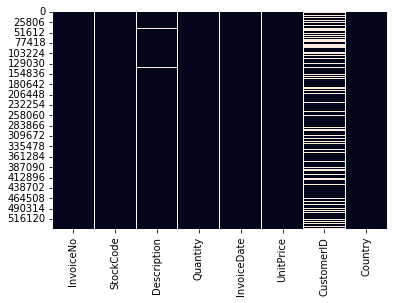

In [30]:
sns.heatmap(df.isnull(), cbar=False)                                                  ## visualising null points

In [31]:
# df['CustomerID'] = df['CustomerID'].apply('str')                                     ## changing customerID to str

In [36]:
(df.isnull().sum()/df.shape[0])*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

We can see that 24 percent of CustomerID values are missing. As we know that in customer segmentation we group data around customer id and we cant impute customer id's. So we are dropping rows corresponding to which customer id is missing

In [37]:
df.dropna(inplace = True)

In [38]:
df.shape

(406829, 8)

## EDA

Let's see how many Invoices are generated by all countries.

In [44]:
df2 = df['Country'].value_counts()
df2 = pd.DataFrame(df2)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

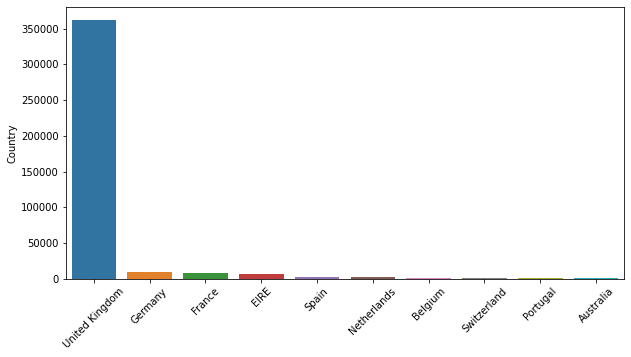

In [42]:
# top 10 countries

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
Country=df2.head(10)
ax = sns.barplot(y='Country',x=Country.index, data=Country)
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

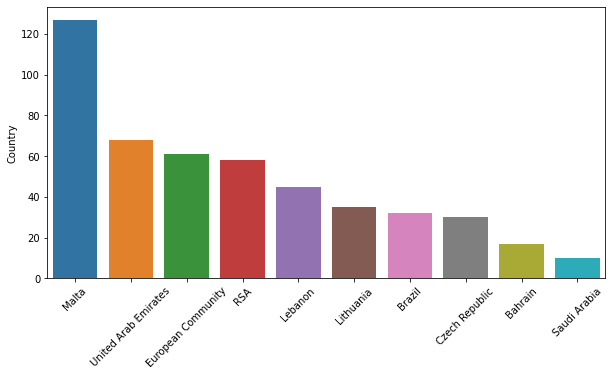

In [43]:
### bottom 10 countries

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
Country=df2.tail(10)
ax = sns.barplot(y='Country',x=Country.index, data=Country)
plt.xticks(rotation=45)

We can see that most of the customers are from United states

Let's create another column amount

In [46]:
df['Amount'] = df['Quantity'] * df['UnitPrice']

In [47]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


Let's convert InvoiceDate to a proper DateTime object

In [51]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%d-%m-%Y %H:%M')                     ### DateTime objective

Lets calculate the frequency of each customer

In [50]:
df_freq = df.groupby('CustomerID')['InvoiceNo'].count().reset_index()                            ## frequency of customer
df_freq = pd.DataFrame(df_freq)
df_freq.columns = ['CustomerID' , 'Freq']

Lets calculate the total money spent by each customer

In [52]:
df_mon = df.groupby('CustomerID')['Amount'].sum().reset_index()                                   ## total amount
df_mon = pd.DataFrame(df_mon)
df_mon.columns = ['CustomerID' , 'Amount']

Merging both dataframe

In [53]:
df2 = df_mon.merge(df_freq,how='inner',on=['CustomerID'])                                          ### merging rowwise

Let's calculate the recency of each customer

In [54]:
max_date = df['InvoiceDate'].max()                                                                 ## last date
df['diff'] = max_date - df['InvoiceDate']                                                          ## diff

In [55]:
df_recen = df.groupby('CustomerID')['diff'].min().reset_index()                                     # diff between last invoice date and last date
df_recen = pd.DataFrame(df_recen)
df_recen.columns = ['CustomerID' , 'recen']

merging all the dataframes

In [56]:
df2 = df2.merge(df_recen,how='inner',on=['CustomerID'])

In [57]:
df2.head()

,CustomerID,Amount,Freq,recen
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [58]:
df2['recen'] = df2['recen'].dt.days                                                        ## extract exact days

In [59]:
# df2.head()

Now lets remove outliers

Text(0.5, 0, 'Attributes')

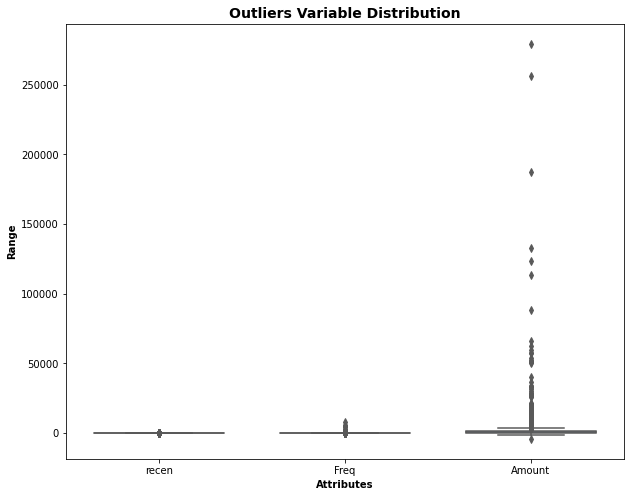

In [60]:
attributes = ['recen','Freq','Amount',]
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df2[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

we will use IQR to remove outliers

In [61]:
df3 = df2.copy()

In [ ]:
### Amount
Q1 = df3['Amount'].quantile(0.05)
Q3 = df3['Amount'].quantile(0.95)
IQR = Q3 - Q1

df3 = df3[(df3['Amount']>= Q1-(1.5*IQR))  &((df3['Amount'] <= Q3 + (1.5*IQR)))]

## freq 
Q1 = df3['Freq'].quantile(0.05)
Q3 = df3['Freq'].quantile(0.95)
IQR = Q3 - Q1

df3 = df3[(df3['Freq']>= Q1-(1.5*IQR))  &((df3['Freq'] <= Q3 + (1.5*IQR)))]

## recen
Q1 = df3['recen'].quantile(0.05)
Q3 = df3['recen'].quantile(0.95)
IQR = Q3 - Q1

df3 = df3[(df3['recen']>= Q1-(1.5*IQR))  &((df3['recen'] <= Q3 + (1.5*IQR)))]

In [68]:
df3.shape

(4293, 4)

Now lets standardise dataset

In [69]:
df4 = df3[['recen','Freq', 'Amount']].copy()

# Instantiate
scaler = StandardScaler()

# fit_transform
df4_scaled = pd.DataFrame(scaler.fit_transform(df4))
df4_scaled.columns = ['recen','Freq', 'Amount']

Text(0.5, 0, 'Attributes')

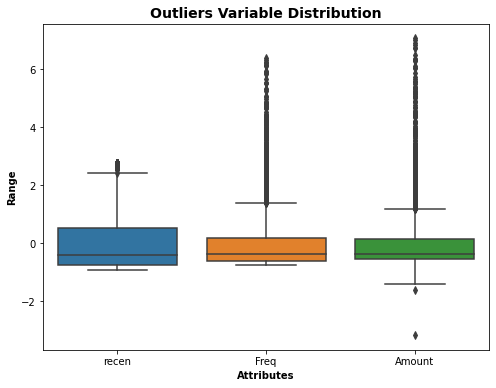

In [70]:
attributes = ['recen','Freq','Amount']
# data = pd.DataFrame(df4_scaled[attributes]
plt.rcParams['figure.figsize'] = [8,6]
sns.boxplot( data = df4_scaled[attributes] )
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

# Clustering

1.Centroid Based Clustering(Kmeans)

In [71]:
sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in tqdm(range(2, kmax)):
  kmeans = KMeans(n_clusters = k).fit(df4_scaled[attributes])
  labels = kmeans.labels_
  sil.append(silhouette_score(df4_scaled[attributes] , labels, metric = 'euclidean'))

100%|██████████| 8/8 [00:03<00:00,  2.02it/s]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


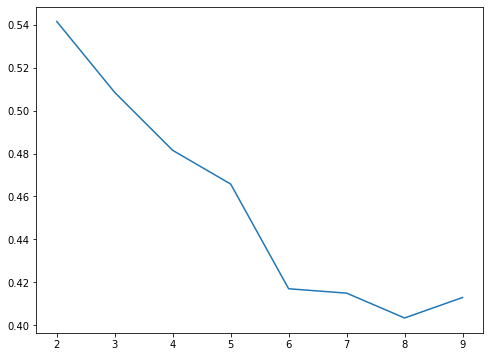

In [72]:
xs2 = [i for i in range(2,kmax)]
sns.lineplot(xs2,sil)

The silhouette_score is maximum at n_clusters = 3. Lets cluster at n_clusters = 3 and visualise the results

In [73]:
df5 = df4_scaled[attributes]

In [74]:
kmeans = KMeans(n_clusters = 3).fit(df5)
df5['labels'] = kmeans.labels_

In [75]:
df5["labels"] = df5["labels"].astype(str) #convert to string
fig = px.scatter_3d(df5, x='recen', y='Freq', z='Amount',
              color='labels')
fig.show()

Let's visualise through boxplot

Text(0.5, 0, 'Attributes')

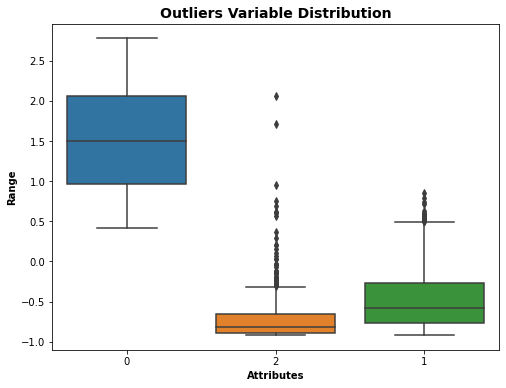

In [76]:
plt.rcParams['figure.figsize'] = [8,6]
sns.boxplot( data = df5 ,x = 'labels' , y = 'recen')
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

Text(0.5, 0, 'Attributes')

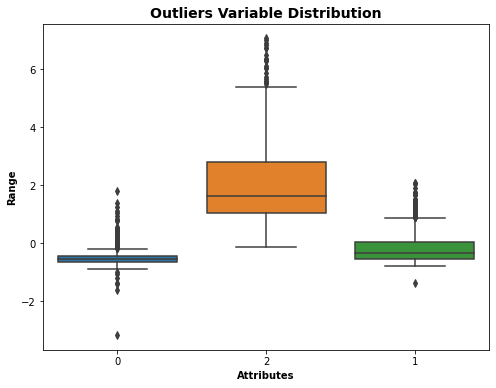

In [77]:
plt.rcParams['figure.figsize'] = [8,6]
sns.boxplot( data = df5 ,x = 'labels' , y = 'Amount')
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

Text(0.5, 0, 'Attributes')

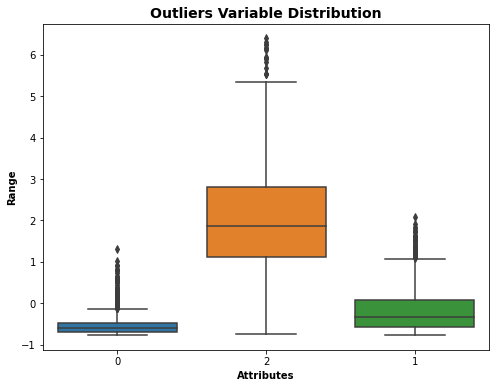

In [78]:
plt.rcParams['figure.figsize'] = [8,6]
sns.boxplot( data = df5 ,x = 'labels' , y = 'Freq')
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

Lets check at n_clusters= 4 too

In [79]:
kmeans = KMeans(n_clusters = 4).fit(df4_scaled[attributes])
labels = kmeans.labels_

Text(0.5, 0, 'Attributes')

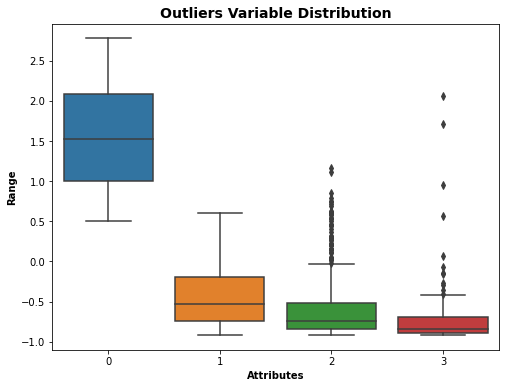

In [80]:
plt.rcParams['figure.figsize'] = [8,6]
sns.boxplot( data = df4_scaled ,x = labels , y = 'recen')
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

Text(0.5, 0, 'Attributes')

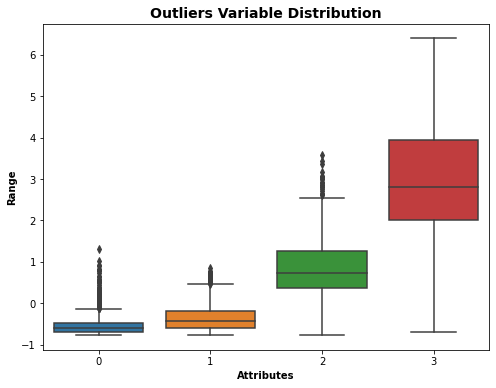

In [81]:
plt.rcParams['figure.figsize'] = [8,6]
sns.boxplot( data = df4_scaled ,x = labels , y = 'Freq')
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

Text(0.5, 0, 'Attributes')

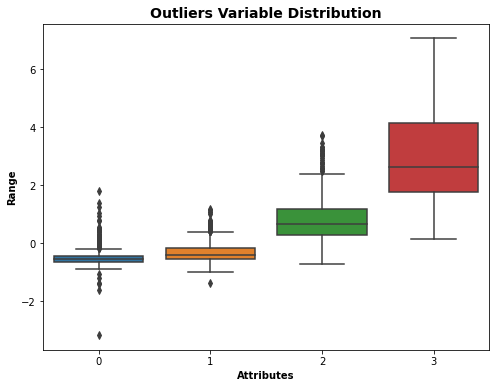

In [82]:
plt.rcParams['figure.figsize'] = [8,6]
sns.boxplot( data = df4_scaled ,x = labels , y = 'Amount')
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

n_clusters = 3 is better that n_clusters = 4

2. Hierarchial clustering


In [83]:
df4_scaled.head()

,recen,Freq,Amount
0,2.301611,-0.752888,-0.723738
1,-0.906466,1.042467,1.731617
2,-0.183658,-0.463636,0.300128
3,-0.738141,-0.044720,0.277517
4,2.143188,-0.603275,-0.533235


Method:Single
#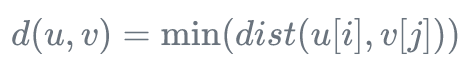

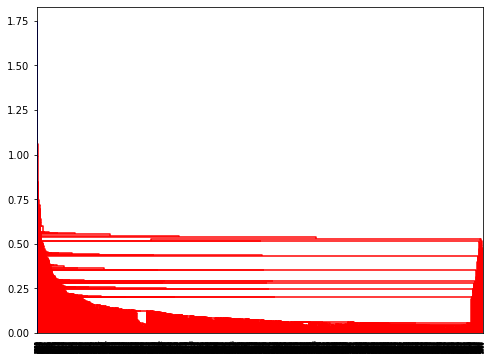

In [84]:
mergings = linkage(df4_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

Method:complete
#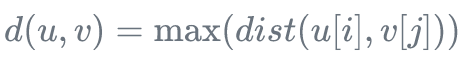

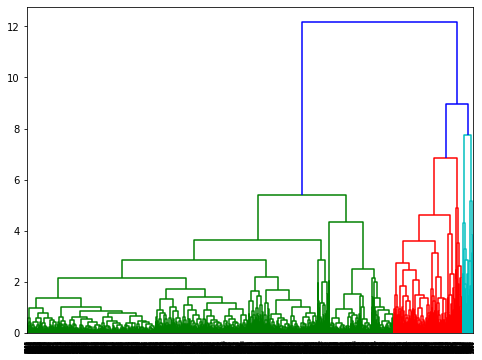

In [85]:
mergings = linkage(df4_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

Method : Average
#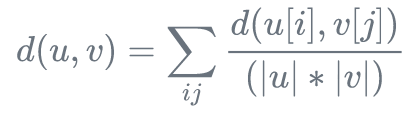

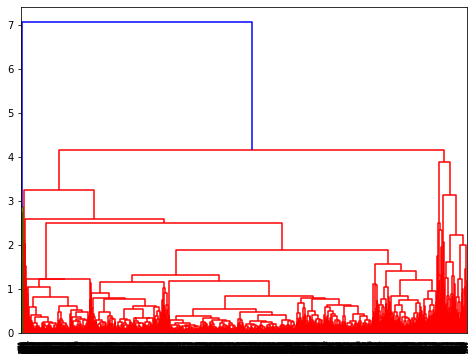

In [86]:
mergings = linkage(df4_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

In [87]:
k=3
cluster_labels = cut_tree(mergings, n_clusters=k).reshape(-1, )                                ### reducing dimension by one
df4_scaled['Cluster_Labels'] = cluster_labels
df4_scaled.head()

,recen,Freq,Amount,Cluster_Labels
0,2.301611,-0.752888,-0.723738,0
1,-0.906466,1.042467,1.731617,0
2,-0.183658,-0.463636,0.300128,0
3,-0.738141,-0.044720,0.277517,0
4,2.143188,-0.603275,-0.533235,0


In [88]:
df4_scaled["Cluster_Labels"] = df4_scaled["Cluster_Labels"].astype(str) #convert to string
fig = px.scatter_3d(df4_scaled, x='recen', y='Freq', z='Amount',
              color='Cluster_Labels')
fig.show()

In [89]:
print("when hierarchial clustering with n_clusters = 3 score is {}".format(silhouette_score(df4_scaled[attributes] , df4_scaled['Cluster_Labels'], metric = 'euclidean')))

when hierarchial clustering with n_clusters = 3 score is 0.5812590418480046


Which is not better than kmeans clustering

3.Density Based Clustering

In [90]:
neigh = NearestNeighbors(n_neighbors = 6)
nbrs = neigh.fit(df4_scaled[attributes])
distances , indices = nbrs.kneighbors(df4_scaled[attributes])

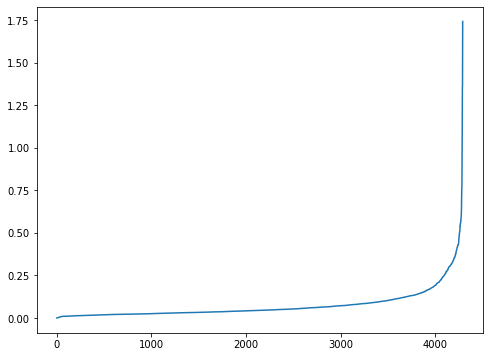

In [91]:
distances = np.sort(distances , axis = 0)
distances = distances[:,1]
plt.plot(distances)

In [92]:
m = DBSCAN(eps = 0.2, min_samples = 6)
m.fit(df4_scaled[attributes])

DBSCAN(eps=0.2, min_samples=6)

In [93]:
labels = m.labels_
print(silhouette_score(df4_scaled[attributes], labels, metric = 'euclidean'))

-0.020454741200257413


In [94]:
# df4_scaled["Cluster_Labels"] = df4_scaled["Cluster_Labels"].astype(str) #convert to string
fig = px.scatter_3d(df4_scaled[attributes], x='recen', y='Freq', z='Amount',
              color=labels)
fig.show()

lets try at 4 min_samples

In [95]:
m = DBSCAN(eps = 0.2, min_samples = 4)
m.fit(df4_scaled[attributes])

DBSCAN(eps=0.2, min_samples=4)

In [96]:
labels = m.labels_
print(silhouette_score(df4_scaled[attributes], labels, metric = 'euclidean'))

-0.13317868686366383


In [97]:
fig = px.scatter_3d(df4_scaled[attributes], x='recen', y='Freq', z='Amount',
              color=labels)
fig.show()

In [ ]:
### change IQR from q1 = 0.05
# q2 = 0.95

## alternate